In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import csv
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn, optim
from torchvision.models import resnet18, ResNet18_Weights
from fastai.vision.learner import create_body
from fastai.vision.models.unet import DynamicUnet
from skimage.color import rgb2lab, lab2rgb
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Model

In [ ]:
class PatchGAN(nn.Module):
    def __init__(self, in_channels=3, num_filters=64, num_layers=3):
        super(PatchGAN, self).__init__()

        layers = []

        layers.append(nn.Conv2d(in_channels, num_filters, kernel_size=4, stride=2, padding=1))
        layers.append(nn.LeakyReLU(0.2, inplace=True))

        for i in range(1, num_layers):
            in_c = num_filters * min(2 ** (i - 1), 8)
            out_c = num_filters * min(2 ** i, 8)
            layers.append(nn.Conv2d(in_c, out_c, kernel_size=4, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(out_c))
            layers.append(nn.LeakyReLU(0.2, inplace=True))

        in_c = num_filters * min(2 ** (num_layers - 1), 8)
        layers.append(nn.Conv2d(in_c, 1, kernel_size=4, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

    def init_weights(self, mean=0.0, std=0.02):
        for m in self.model.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, mean=mean, std=std)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.normal_(m.weight, mean=1.0, std=std)
                nn.init.constant_(m.bias, 0.0)

In [ ]:
def build_res18_unet(n_input=1, n_output=2, size=128):
    backbone = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    # backbone = resnet18(weights=ResNet18_Weights.DEFAULT)
    body = create_body(backbone, n_in=n_input, cut=-2)
    model = DynamicUnet(body, n_output, (size, size))

    return model

In [ ]:
def pretrain_generator(model, train_loader, epochs):
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    weight_updates = 0
    total_loss = 0
    for epoch in range(epochs):
        for data in tqdm(train_loader):
            L, ab = data['L'].to(device), data['ab'].to(device)
            preds = model(L)
            loss = criterion(preds, ab)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            weight_updates += 1

        print(f"\nEpoch {epoch + 1}/{epochs}")
        print(f"L1 Loss: {total_loss / weight_updates:.5f}")

    save_path = '/content/drive/MyDrive/DL_project/gan_unet/res18-unet.pt'
    torch.save(model.state_dict(), save_path)

In [ ]:
class Colorizer(nn.Module):
    def __init__(self, G_net, G_lr=1e-5, D_lr=1e-5, beta1=0.5, beta2=0.999, Lambda = 100.):
        super().__init__()
        self.Lambda = Lambda
        self.GANLoss = nn.BCEWithLogitsLoss()
        self.L1Loss = nn.L1Loss()
        self.G_net = G_net.to(device)
        self.D_net = PatchGAN()
        self.D_net.init_weights()
        self.G_optimizer = optim.Adam(self.G_net.parameters(), lr=G_lr, betas=(beta1, beta2))
        self.D_optimizer = optim.Adam(self.D_net.parameters(), lr=D_lr, betas=(beta1, beta2))

    def forward(self, L):
        return self.G_net(L)

    def D_backward(self, fake_img, real_img):
        fake_pred = self.D_net(fake_img.detach())
        fake_target = torch.full_like(fake_pred, False, dtype=fake_pred.dtype, device=fake_pred.device)
        D_loss_fake = self.GANLoss(fake_pred, fake_target)
        real_pred = self.D_net(real_img)
        real_target = torch.full_like(real_pred, True, dtype=real_pred.dtype, device=real_pred.device)
        D_loss_real = self.GANLoss(real_pred, real_target)
        D_loss = (D_loss_fake + D_loss_real) / 2
        D_loss.backward()

        return D_loss_fake.item(), D_loss_real.item(), D_loss.item()

    def G_backward(self, fake_img, fake_ab, ab):
        fake_pred = self.D_net(fake_img)
        real_target = torch.full_like(fake_pred, True, dtype=fake_pred.dtype, device=fake_pred.device)
        G_loss_GAN = self.GANLoss(fake_pred, real_target)
        G_loss_l1 = self.L1Loss(fake_ab, ab)
        G_loss = G_loss_GAN + self.Lambda * G_loss_l1
        G_loss.backward()

        return G_loss_GAN.item(), G_loss_l1.item(), G_loss.item()

    def train_model(self, L, ab):
        fake_ab = self.G_net(L)
        fake_img = torch.cat([L, fake_ab], dim=1)
        real_img = torch.cat([L, ab], dim=1)

        for param in self.D_net.parameters():
            param.requires_grad = True
        self.D_net.train()
        self.D_optimizer.zero_grad()
        D_loss_fake, D_loss_real, D_loss = self.D_backward(fake_img, real_img)
        self.D_optimizer.step()

        for param in self.D_net.parameters():
            param.requires_grad = False
        self.G_net.train()
        self.G_optimizer.zero_grad()
        G_loss_GAN, G_loss_L1, G_loss = self.G_backward(fake_img, fake_ab, ab)
        self.G_optimizer.step()

        return D_loss_fake, D_loss_real, D_loss, G_loss_GAN, G_loss_L1, G_loss

In [ ]:
G_net = build_res18_unet(n_input=1, n_output=2, size=128).to(device)
G_net.load_state_dict(torch.load("/content/drive/MyDrive/DL_project/gan_unet/res18-unet.pt", map_location=device))
model = Colorizer(G_net=G_net).to(device)

<ipython-input-12-9b1bac2fc460>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G_net.load_state_dict(torch.load("/content/drive/MyDrive/DL_project/gan_unet/res18-unet.pt",

# Dataset

In [ ]:
class LabDataset(Dataset):
    def __init__(self, lab_data):
        self.L = lab_data[..., 0:1]  # L channel (grayscale)
        self.ab = lab_data[..., 1:]  # ab channels (color information)

    def __len__(self):
        return len(self.L)

    def __getitem__(self, idx):
        return {
            # (C, H, W)
            "L": torch.tensor(self.L[idx], dtype=torch.float32).permute(2, 0, 1),
            "ab": torch.tensor(self.ab[idx], dtype=torch.float32).permute(2, 0, 1),
        }

In [ ]:
def load_data(file_path):
    data = np.load(file_path)
    print(data.shape)
    # plt.imshow(data[0])
    # plt.show()

    return data

In [ ]:
def prepare_dataset(data, batch_size=128):
    # (num_samples, H, W, C)
    lab_data = np.array([rgb2lab(image) for image in data])

    def plot_sample():
        sample_lab = lab_data[123]
        l_channel, a_channel, b_channel = sample_lab[..., 0], sample_lab[..., 1], sample_lab[..., 2]

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("L Channel")
        plt.imshow(l_channel, cmap="gray")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title("A Channel")
        plt.imshow(a_channel)
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.title("B Channel")
        plt.imshow(b_channel)
        plt.axis("off")

        plt.show()

    plot_sample()

    # Normalize LAB channels to [-1, 1]
    lab_data[..., 0] = lab_data[..., 0] / 50.0 - 1.0 # L channel range is [0, 100]
    lab_data[..., 1] = lab_data[..., 1] / 128.0  # A channel range is [-128, 127]
    lab_data[..., 2] = lab_data[..., 2] / 128.0  # B channel range is [-128, 127]

    train_data, val_data = train_test_split(lab_data, test_size=0.2, random_state=42)

    train_dataset = LabDataset(train_data)
    val_dataset = LabDataset(val_data)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

    return train_loader, val_loader

(10000, 128, 128, 3)


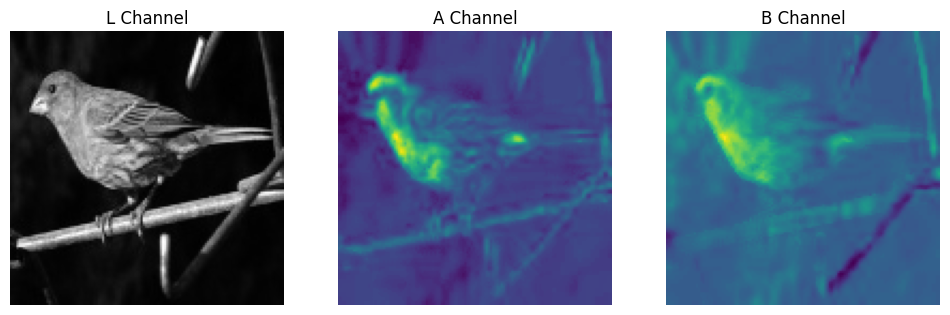

In [ ]:
file_path = '/content/drive/MyDrive/DL_project/image_batch_rgb.npy'
# file_path = '/content/drive/MyDrive/UPenn/ESE 5460/'
data = load_data(file_path)
train_loader, val_loader = prepare_dataset(data)

In [ ]:
res18_unet = build_res18_unet(n_input=1, n_output=2, size=128).to(device)
pretrain_generator(res18_unet, train_loader, epochs=20)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 225MB/s]
100%|██████████| 63/63 [00:14<00:00,  4.45it/s]



Epoch 1/20
L1 Loss: 0.08887


100%|██████████| 63/63 [00:12<00:00,  5.24it/s]



Epoch 2/20
L1 Loss: 0.08151


100%|██████████| 63/63 [00:12<00:00,  5.25it/s]



Epoch 3/20
L1 Loss: 0.07842


100%|██████████| 63/63 [00:12<00:00,  5.24it/s]



Epoch 4/20
L1 Loss: 0.07661


100%|██████████| 63/63 [00:12<00:00,  5.24it/s]



Epoch 5/20
L1 Loss: 0.07530


100%|██████████| 63/63 [00:12<00:00,  5.24it/s]



Epoch 6/20
L1 Loss: 0.07431


100%|██████████| 63/63 [00:12<00:00,  5.21it/s]



Epoch 7/20
L1 Loss: 0.07341


100%|██████████| 63/63 [00:12<00:00,  5.24it/s]



Epoch 8/20
L1 Loss: 0.07254


100%|██████████| 63/63 [00:12<00:00,  5.24it/s]



Epoch 9/20
L1 Loss: 0.07166


100%|██████████| 63/63 [00:12<00:00,  5.23it/s]



Epoch 10/20
L1 Loss: 0.07074


100%|██████████| 63/63 [00:12<00:00,  5.23it/s]



Epoch 11/20
L1 Loss: 0.06979


100%|██████████| 63/63 [00:12<00:00,  5.23it/s]



Epoch 12/20
L1 Loss: 0.06889


100%|██████████| 63/63 [00:12<00:00,  5.23it/s]



Epoch 13/20
L1 Loss: 0.06803


100%|██████████| 63/63 [00:12<00:00,  5.23it/s]



Epoch 14/20
L1 Loss: 0.06717


100%|██████████| 63/63 [00:12<00:00,  5.24it/s]



Epoch 15/20
L1 Loss: 0.06634


100%|██████████| 63/63 [00:12<00:00,  5.23it/s]



Epoch 16/20
L1 Loss: 0.06558


100%|██████████| 63/63 [00:12<00:00,  5.23it/s]



Epoch 17/20
L1 Loss: 0.06485


100%|██████████| 63/63 [00:12<00:00,  5.22it/s]



Epoch 18/20
L1 Loss: 0.06415


100%|██████████| 63/63 [00:12<00:00,  5.24it/s]



Epoch 19/20
L1 Loss: 0.06350


100%|██████████| 63/63 [00:12<00:00,  5.22it/s]



Epoch 20/20
L1 Loss: 0.06286


In [ ]:
G_net = build_res18_unet(n_input=1, n_output=2, size=128).to(device)
G_net.load_state_dict(torch.load("/content/drive/MyDrive/DL_project/gan_unet/res18-unet.pt", map_location=device))

<ipython-input-14-2589b2353b65>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G_net.load_state_dict(torch.load("/content/drive/MyDrive/DL_project/gan_unet/res18-unet.pt",

<All keys matched successfully>

In [ ]:
def train(model, train_loader, val_loader, epochs, eval_freq=5):
    weight_updates = 0
    ckpt_dir = "/content/drive/MyDrive/DL_project/gan_unet/ckpt"
    os.makedirs(ckpt_dir, exist_ok=True)

    losses = {
        'update': [],
        'D_loss_fake': [],
        'D_loss_real': [],
        'D_loss': [],
        'G_loss_GAN': [],
        'G_loss_L1': [],
        'G_loss': []
    }

    for epoch in range(epochs):
        for data in tqdm(train_loader):
            L, ab = data['L'].to(device), data['ab'].to(device)
            D_loss_fake, D_loss_real, D_loss, G_loss_GAN, G_loss_L1, G_loss = model.train_model(L, ab)

            losses['update'].append(weight_updates)
            losses['D_loss_fake'].append(D_loss_fake)
            losses['D_loss_real'].append(D_loss_real)
            losses['D_loss'].append(D_loss)
            losses['G_loss_GAN'].append(G_loss_GAN)
            losses['G_loss_L1'].append(G_loss_L1)
            losses['G_loss'].append(G_loss)

            weight_updates += 1

        print(f"\nEpoch {epoch + 1}/{epochs}")
        if (epoch + 1) % eval_freq == 0:
            ckpt_path = os.path.join(ckpt_dir, f"model_epoch_{epoch + 1}.pt")
            torch.save(model.state_dict(), ckpt_path)
            visualize(model, val_loader, epoch=epoch + 1, save=True)

    loss_path = '/content/drive/MyDrive/DL_project/gan_unet/losses.csv'
    with open(loss_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(
            ['Update', 'D_loss_fake', 'D_loss_real', 'D_loss', 'G_loss_GAN', 'G_loss_L1', 'G_loss'])
        for i in range(len(losses['update'])):
            writer.writerow([
                losses['update'][i],
                losses['D_loss_fake'][i],
                losses['D_loss_real'][i],
                losses['D_loss'][i],
                losses['G_loss_GAN'][i],
                losses['G_loss_L1'][i],
                losses['G_loss'][i]
            ])

model initialized with norm initialization


100%|██████████| 63/63 [00:14<00:00,  4.27it/s]



Epoch 1/20


100%|██████████| 63/63 [00:14<00:00,  4.35it/s]



Epoch 2/20


100%|██████████| 63/63 [00:14<00:00,  4.34it/s]



Epoch 3/20


100%|██████████| 63/63 [00:14<00:00,  4.32it/s]



Epoch 4/20


100%|██████████| 63/63 [00:14<00:00,  4.32it/s]



Epoch 5/20


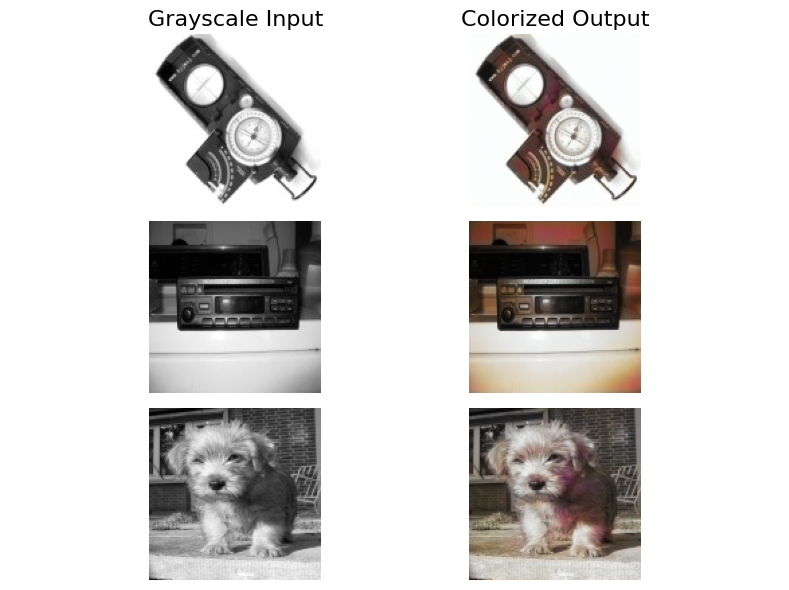

100%|██████████| 63/63 [00:14<00:00,  4.35it/s]



Epoch 6/20


100%|██████████| 63/63 [00:14<00:00,  4.36it/s]



Epoch 7/20


100%|██████████| 63/63 [00:14<00:00,  4.35it/s]



Epoch 8/20


100%|██████████| 63/63 [00:14<00:00,  4.35it/s]



Epoch 9/20


100%|██████████| 63/63 [00:14<00:00,  4.36it/s]



Epoch 10/20


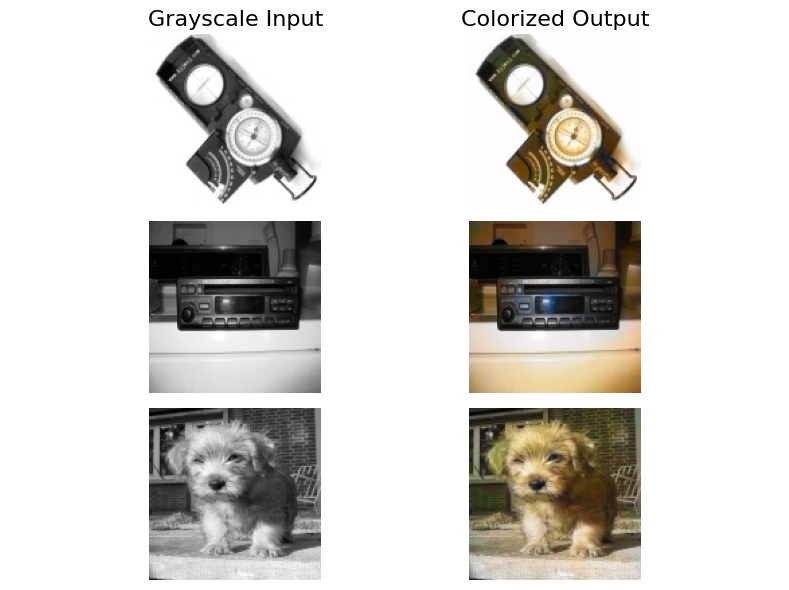

100%|██████████| 63/63 [00:14<00:00,  4.34it/s]



Epoch 11/20


100%|██████████| 63/63 [00:14<00:00,  4.28it/s]



Epoch 12/20


100%|██████████| 63/63 [00:14<00:00,  4.33it/s]



Epoch 13/20


100%|██████████| 63/63 [00:14<00:00,  4.34it/s]



Epoch 14/20


100%|██████████| 63/63 [00:14<00:00,  4.34it/s]



Epoch 15/20


<ipython-input-18-a0fd8f6f6ed9>:29: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 39 negative Z values that have been clipped to zero
  rgb_image = lab2rgb(lab_image)  # Convert Lab to RGB


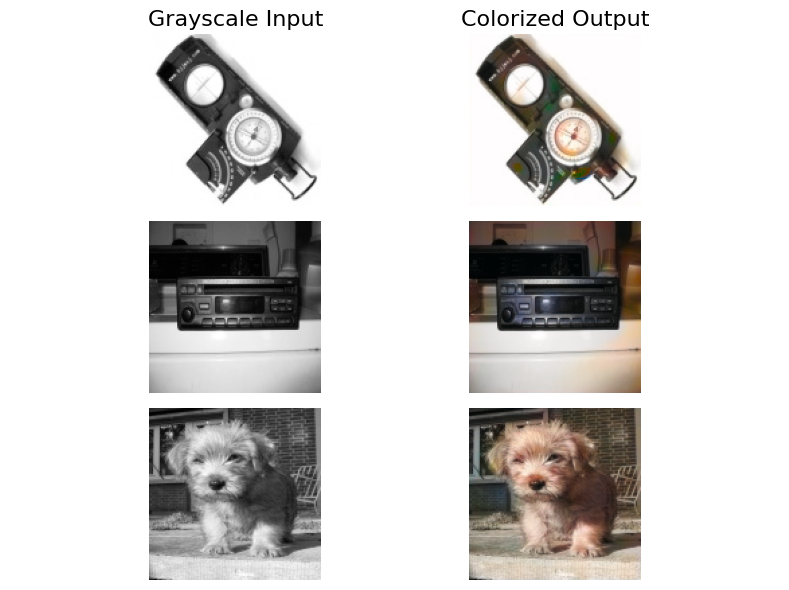

100%|██████████| 63/63 [00:14<00:00,  4.33it/s]



Epoch 16/20


100%|██████████| 63/63 [00:14<00:00,  4.33it/s]



Epoch 17/20


100%|██████████| 63/63 [00:14<00:00,  4.34it/s]



Epoch 18/20


100%|██████████| 63/63 [00:14<00:00,  4.34it/s]



Epoch 19/20


100%|██████████| 63/63 [00:14<00:00,  4.36it/s]



Epoch 20/20


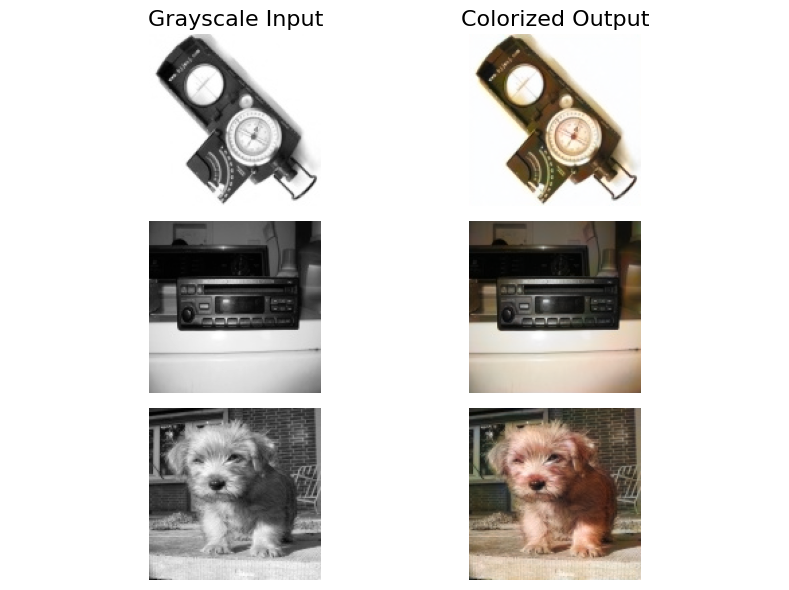

In [ ]:
model = Colorizer(G_net=G_net)
train(model, train_loader, val_loader, 20)

# Evaluation

In [ ]:
import cv2
from scipy.linalg import sqrtm
from torchvision import models, transforms
from torch.nn.functional import adaptive_avg_pool2d

Load model

In [ ]:
G_net = build_res18_unet(n_input=1, n_output=2, size=128).to(device)
G_net.load_state_dict(torch.load("/content/drive/MyDrive/DL_project/gan_unet/res18-unet.pt", map_location=device))
model = Colorizer(G_net=G_net).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/DL_project/gan_unet/epoch20_pretrain/ckpt/model_epoch_20.pt", map_location=device))
model.eval()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 221MB/s]
<ipython-input-14-ada0593e4846>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded

model initialized with norm initialization


<ipython-input-14-ada0593e4846>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/MyDrive/DL_project/gan_unet/epoch20_pretrai

Colorizer(
  (GANLoss): BCEWithLogitsLoss()
  (L1Loss): L1Loss()
  (G_net): DynamicUnet(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 6

In [ ]:
def lab_to_rgb(L, ab):
    L = L.cpu().numpy()  # Shape: (N, 1, H, W)
    ab = ab.cpu().numpy()  # Shape: (N, 2, H, W)

    Lab = np.concatenate([L, ab], axis=1)  # Shape: (N, 3, H, W)
    Lab = Lab.transpose(0, 2, 3, 1)  # Shape: (N, H, W, 3)

    rgb_images = []
    for i in range(Lab.shape[0]):
        lab_image = Lab[i]
        lab_image[:, :, 0] = lab_image[:, :, 0] * 100.0
        lab_image[:, :, 1:] = lab_image[:, :, 1:] * 128.0
        rgb_image = lab2rgb(lab_image)
        rgb_images.append(rgb_image)

    return np.stack(rgb_images, axis=0)

FID

In [ ]:
class InceptionFeatureExtractor:
    def __init__(self):
        self.model = models.inception_v3(pretrained=True, transform_input=False)
        self.model.fc = torch.nn.Identity()
        self.model.eval()
        self.model.to(device)

    def get_features(self, images):
        with torch.no_grad():
            features = self.model(images.to(device))

        return features.view(features.size(0), -1).cpu().numpy()

In [ ]:
def compute_fid(real_features, fake_features):
    mu_real = np.mean(real_features, axis=0)
    mu_fake = np.mean(fake_features, axis=0)
    sigma_real = np.cov(real_features, rowvar=False)
    sigma_fake = np.cov(fake_features, rowvar=False)

    cov_sqrt, _ = sqrtm(sigma_real @ sigma_fake, disp=False)

    if np.iscomplexobj(cov_sqrt):
        cov_sqrt = cov_sqrt.real

    diff = mu_real - mu_fake
    fid = diff @ diff + np.trace(sigma_real + sigma_fake - 2 * cov_sqrt)

    return fid

In [ ]:
def preprocess(images):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((299, 299)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    images = torch.stack([transform(image) for image in images])

    return images.to(device)

Colorfulness

In [ ]:
def compute_colorfulness(image):
    if image.max() <= 1.0:
        image = (image * 255).astype("float")
    else:
        image = image.astype("float")


    R, G, B = image[..., 0], image[..., 1], image[..., 2]

    rg = np.abs(R - G)
    yb = np.abs(0.5 * (R + G) - B)

    rg_mean, rg_std = np.mean(rg), np.std(rg)
    yb_mean, yb_std = np.mean(yb), np.std(yb)

    std_root = np.sqrt(rg_std**2 + yb_std**2)

    mean_root = np.sqrt(rg_mean**2 + yb_mean**2)

    colorfulness = std_root + (0.3 * mean_root)

    return colorfulness

In [ ]:
def evaluation(model, val_loader, feature_extractor):
    real_features = []
    fake_features = []
    colorfulness_scores = []

    for batch in val_loader:
        L, ab = batch['L'].to(device), batch['ab'].to(device)

        with torch.no_grad():
            pred_ab = model(L)

        real_images = lab_to_rgb(L, ab)
        fake_images = lab_to_rgb(L, pred_ab)

        for img in fake_images:
            colorfulness = compute_colorfulness(img)
            colorfulness_scores.append(colorfulness)

        real_images = preprocess(real_images)
        fake_images = preprocess(fake_images)

        real_features.append(feature_extractor.get_features(real_images))
        fake_features.append(feature_extractor.get_features(fake_images))

    real_features = np.concatenate(real_features, axis=0)
    fake_features = np.concatenate(fake_features, axis=0)

    fid_score = compute_fid(real_features, fake_features)
    print(f"FID Score for Colorization: {fid_score}")

    avg_colorfulness = np.mean(colorfulness_scores)
    print(f"Average Colorfulness: {avg_colorfulness}")

In [ ]:
feature_extractor = InceptionFeatureExtractor()
evaluation(model, val_loader, feature_extractor)

流式输出内容被截断，只能显示最后 5000 行内容。
<ipython-input-20-70a3033cc5a4>:13: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 6005 negative Z values that have been clipped to zero
  rgb_image = lab2rgb(lab_image)
<ipython-input-20-70a3033cc5a4>:13: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 12708 negative Z values that have been clipped to zero
  rgb_image = lab2rgb(lab_image)
<ipython-input-20-70a3033cc5a4>:13: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 11713 negative Z values that have been clipped to zero
  rgb_image = lab2rgb(lab_image)
<ipython-input-20-70a3033cc5a4>:13: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 4881 negative Z values that have been clipped to zero
  rgb_image = lab2rgb(lab_image)
<ipython-input-20-70a3033cc5a4>:13: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 6618 negative Z values that have been clipped to zero

FID Score for Colorization: 18.500633666435867
Average Colorfulness: 18.373098718200694
